In [1]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import math
import seaborn as sns 
import umap
import umap.plot
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
randomstate = 42
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
import plotly.express as px
import molplotly
import mols2grid

**Load data**

In [2]:
ci = pd.read_excel('example_descriptors.xlsx','descriptors',index_col=0,header=1,engine='openpyxl')
compinp = ci[ci.columns[1:-3]].loc[ci.index[:]]
compinp.index = compinp.index.astype(int)
compinp.dropna(axis=0,inplace=True)

inp2 = pd.read_excel("example_identifiers.xlsx",index_col=1,header=2,engine='openpyxl')
inp2.index = inp2.index.astype(int)

#rxndata = pd.read_excel("example_rxn_data.xlsx","reactions",header=2,index_col=2,nrows=1776,engine='openpyxl')

print(len(inp2.index),'ligands in identifiers file')
print(len(compinp.index),'ligands in descriptors file')

1776 ligands in identifiers file
1544 ligands in descriptors file


**Remove colinear descriptors and descriptors with all values = 0 (optional)**

In [3]:
threshold = 0.95  # Pearson correlation coefficient (r) value

print('Shape of descriptors file before curation: ',compinp.shape)
#compinp = compinp.astype(float)
df_corr = compinp.corr()
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
compinp = compinp[un_corr_idx]

compinp = compinp.loc[:, (compinp != 0).any(axis=0)]

print('Shape of descriptors file after curation: ',compinp.shape)

Shape of descriptors file before curation:  (1544, 190)
Shape of descriptors file after curation:  (1544, 139)


**Scale the data and run UMAP**

In [4]:
X_all = np.array(compinp)
X_all_ids = np.array(compinp.index)
X_all_names = np.array(inp2["ligand"].loc[X_all_ids])
X_all_smiles = np.array(inp2['SMILES'].loc[X_all_ids])

scaler = StandardScaler()   # calculate z-scores
scaler.fit(X_all)           # compute the mean and std deviation
X_all_sc = scaler.transform(X_all)

reducer = umap.UMAP(random_state=42)
reducer.fit(X_all_sc)
X_all_red = reducer.transform(X_all_sc)

**Standard score plot**

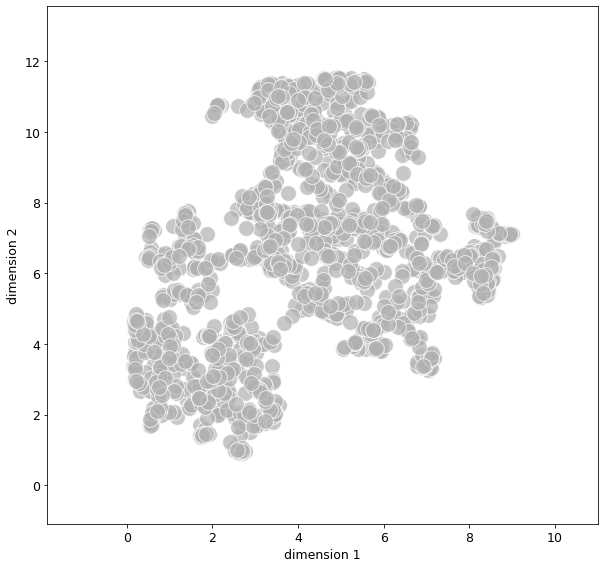

In [22]:
x_min, x_max = X_all_red[:,0].min() - 2,X_all_red[:,0].max() + 2
y_min, y_max = X_all_red[:,1].min() - 2,X_all_red[:,1].max() + 2
plt.figure(figsize=(8.5,8))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=12.5) 
plt.yticks(fontsize=12.5)
plt.xlabel(f"dimension 1",fontsize=12.5)
plt.ylabel(f"dimension 2",fontsize=12.5)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.scatter(X_all_red[:,0], X_all_red[:,1],c='#B1B1B1',alpha=0.7,marker=".",s=1000,edgecolor='white')

### plot labels
#for i in range(0,len(X_all_red)):
#    plt.text(X_all_red[i,0],X_all_red[i,1]," "+str(X_all_ids[i]),color="red",fontsize=10,ha="left") 

plt.tight_layout()
#plt.show()  
#plt.savefig("umap1.png",dpi=300)

**Interactive score plot**

https://www.wmccorkindale.com/post/introducing-molplotly

https://github.com/wjm41/molplotly

In [6]:
df_1 = pd.DataFrame(X_all_red, columns = ['dimension 1', 'dimension 2'])
df_1['ID'] = X_all_ids
df_1['smiles'] = X_all_smiles
df_1['names'] = X_all_names
df_1

,dimension 1,dimension 2,ID,smiles,names
0,8.583771,6.159716,1,CC(c1cc(cc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)C(C)C...,Xphos
1,8.063353,6.157094,2,CN(c1cccc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)N(C)C)C,CPhos
2,8.120197,6.503950,3,COc1cccc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)OC,SPhos
3,8.424070,6.222067,4,CC(Oc1cccc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)OC(C)C)C,RuPhos
4,7.527716,6.409277,5,C1CCC(CC1)P(c1ccccc1c1ccccc1)C1CCCCC1,CyJohnPhos
...,...,...,...,...,...
1539,8.381744,7.472427,1904,c1ccccc1,x
1540,2.551249,6.425488,1905,c1ccccc1,x
1541,8.362308,5.959936,1906,c1ccccc1,x
1542,2.780531,3.568997,1907,c1ccccc1,x


In [7]:
fig_pca = px.scatter(df_1,
                     x="dimension 1",
                     y="dimension 2",
                     #color='y_true',
                     title='UMAP plot',
                     #labels={'y_true': 'Measured Solubility'},
                     width=900,
                     height=900)

app_pca = molplotly.add_molecules(fig=fig_pca,
                                  df=df_1,
                                  smiles_col='smiles',
                                  title_col='names',
                                  caption_cols=['ID'],
                                  #color_col='y_true',
                                  show_coords=False)

app_pca.run_server(mode='inline', port=8006, height=850)

**Run K-means and HDBSCAN clustering**

In [12]:
### run umap
clusterable_embedding = umap.UMAP(random_state=42).fit_transform(X_all_sc)
#clusterable_embedding = umap.UMAP(n_neighbors=30,min_dist=0.0,n_components=2,random_state=42).fit_transform(X_all_sc)


### run k-means
number_clusters = 10
kmeans = KMeans(n_clusters=number_clusters, random_state=42).fit(clusterable_embedding)

dists = [] #distances for each ligand from cluster centre
for x in range(len(clusterable_embedding)):
    delta = [clusterable_embedding[x,i]-kmeans.cluster_centers_[kmeans.labels_[x],i] for i in range(len(clusterable_embedding[0]))]
    dist = np.linalg.norm(delta)
    dists.append(dist)

clusters = {}       # key = cluster number, value = indices (row numbers) of the ligands in that cluster (0 indexed)
clusterdists = {}   # key = cluster number, value = distance of ligand to the centroid
clustermins = []    # indices of the ligands closest to the cluster centre

for x in range(number_clusters):
    clusters[x] = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == x]
    clusterdists[x] = [dists[i] for i in clusters[x]]
    clustermins.append(clusters[x][clusterdists[x].index(min(clusterdists[x]))])

row_id = list(enumerate(X_all_ids)) # the row and corresponding ids
clusters_with_ids = {}
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append(row_id[clusters[i][j]][1])
    clusters_with_ids[i] = emptylist

centroids_with_ids = []
for j in clustermins:
    for i in range(0,len(row_id)):
        if row_id[i][0] == j:
            centroids_with_ids.append(row_id[i][1])

df_1['K-means clusters']=kmeans.labels_.astype(str)
df_1['K-means distances']=dists 
df_1['K-means centroids'] = 1
for i in clustermins:
    df_1.at[i,'K-means centroids']=10


### run hdbscan
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=50).fit_predict(clusterable_embedding)
df_1['HDBSCAN clusters']=hdbscan_labels.astype(str)    
    
df_1

,dimension 1,dimension 2,ID,smiles,names,K-means clusters,K-means distances,K-means centroids,HDBSCAN clusters
0,8.583771,6.159716,1,CC(c1cc(cc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)C(C)C...,Xphos,3,0.782391,1,2
1,8.063353,6.157094,2,CN(c1cccc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)N(C)C)C,CPhos,3,0.400910,1,2
2,8.120197,6.503950,3,COc1cccc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)OC,SPhos,3,0.232545,1,2
3,8.424070,6.222067,4,CC(Oc1cccc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)OC(C)C)C,RuPhos,3,0.612111,1,2
4,7.527716,6.409277,5,C1CCC(CC1)P(c1ccccc1c1ccccc1)C1CCCCC1,CyJohnPhos,3,0.376284,1,2
...,...,...,...,...,...,...,...,...,...
1539,8.381744,7.472427,1904,c1ccccc1,x,3,1.074862,1,2
1540,2.551249,6.425488,1905,c1ccccc1,x,0,1.280393,1,2
1541,8.362308,5.959936,1906,c1ccccc1,x,3,0.732092,1,2
1542,2.780531,3.568997,1907,c1ccccc1,x,1,0.431244,1,0


**K-means clusters**

In [15]:
fig_pca = px.scatter(df_1,
                     x="dimension 1",
                     y="dimension 2",
                     size='K-means centroids', # or K-means distances or comment out
                     color='K-means clusters',
                     title='Clustered UMAP plot',
                     labels={'K-means clusters': 'Cluster'},
                     width=900,
                     height=900)

app_pca = molplotly.add_molecules(fig=fig_pca,
                                  df=df_1,
                                  smiles_col='smiles',
                                  title_col='names',
                                  caption_cols=['ID'],
                                  color_col='K-means clusters',
                                  show_coords=False)

app_pca.run_server(mode='inline', port=8006, height=850)

**Print molecules nearest centroids**

https://github.com/cbouy/mols2grid

https://practicalcheminformatics.blogspot.com/2021/07/viewing-clustered-chemical-structures.html

In [17]:
centroids = df_1.loc[df_1['K-means centroids'] == 10]
centroids

,dimension 1,dimension 2,ID,smiles,names,K-means clusters,K-means distances,K-means centroids,HDBSCAN clusters
335,5.779563,7.786168,342,CC(P(C1=CC=CC=C1)C2=CC=CC=C2)C34C5C6C7C3[Fe]46...,PPhh2(1-Ferrocenyl-ethyl),9,0.222447,10,2
418,2.642876,3.858109,434,CN1CCCN(P1c1ccccc1)C,PPh NMe diazaphosphinane,1,0.116422,10,0
614,0.780137,3.288598,662,P(N(CC)CC)(OCC)OCC,P(OEt)2NEt2,8,0.032050,10,0
837,2.478867,2.027408,983,N1(C=CC2=C1C=CC=C2)P(N3C=CC4=C3C=CC=C4)N5C=CC6...,P(Indolyl)3,4,0.073665,10,0
1084,5.476250,10.501503,1258,Cc1cc(P(CO)c2ccc(-c3ccccc3)c(C)c2)ccc1-c1ccccc1,P(3Me4PhPh)2CH2OH,7,0.099642,10,2
1139,3.610644,10.300109,1415,P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CN=CC=C3,PPh2(3-pyridine),2,0.112252,10,2
1152,7.871508,6.526335,1436,CN(C(C1=CC=CC=C1)=C2P(C3CCCCC3)C4CCCCC4)C5=C2C...,NMe2Ph3PCy2_Indole,3,0.018689,10,2
1180,5.911041,4.613219,1477,CC1=C([Si](C)(C)C)P2C3=C(C1C(C)=C2[Si](C)(C)C)...,Me2TMS2Benzophosphabarrellene,6,0.026057,10,2
1422,3.638448,7.008888,1730,c1ccccc1,x,0,0.075536,10,2
1522,1.224250,6.486303,1831,c1ccccc1,x,5,0.066620,10,1


In [18]:
grid = mols2grid.MolGrid(centroids, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["names", "img"], n_cols=5)

**Print molecules in a certain cluster**

In [19]:
cluster_no = '0'
cluster_mols = df_1.loc[df_1['K-means clusters'] == cluster_no]
cluster_mols

,dimension 1,dimension 2,ID,smiles,names,K-means clusters,K-means distances,K-means centroids,HDBSCAN clusters
9,4.559241,5.724137,10,CCCCP([C@]12C[C@H]3C[C@@H](C2)C[C@@H](C1)C3)[C...,CataCXium A,0,1.515203,1,2
10,4.059556,5.992140,11,C1CCC(CC1)P(C1CCCCC1)C1CCCCC1,PCy3,0,1.045963,1,2
18,4.268106,7.732272,19,c1ccc(cc1)CP(c1ccccc1)c1ccccc1,PBnPh2,0,0.941108,1,2
19,3.730831,6.338024,20,CCCCP(CCCC)CCCC,PnBu3,0,0.639268,1,2
31,4.265635,5.542895,32,CC(P(C1CCCCC1)C1CCCCC1)(C)C,PtBuCy2,0,1.538975,1,2
...,...,...,...,...,...,...,...,...,...
1493,3.586179,6.110055,1802,c1ccccc1,x,0,0.875146,1,2
1506,4.280065,7.379275,1815,c1ccccc1,x,0,0.700377,1,2
1531,3.765011,8.275590,1840,c1ccccc1,x,0,1.300050,1,-1
1533,4.195930,7.401592,1842,c1ccccc1,x,0,0.647775,1,2


In [20]:
grid = mols2grid.MolGrid(cluster_mols, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["names", "img"], n_cols=5)

**HDBSCAN clusters**

In [21]:
fig_pca = px.scatter(df_1,
                     x="dimension 1",
                     y="dimension 2",
                     #size='K-means centroids',
                     color='HDBSCAN clusters',
                     title='Clustered UMAP plot',
                     labels={'HDBSCAN clusters': 'Cluster'},
                     width=900,
                     height=900)

app_pca = molplotly.add_molecules(fig=fig_pca,
                                  df=df_1,
                                  smiles_col='smiles',
                                  title_col='names',
                                  caption_cols=['ID'],
                                  color_col='HDBSCAN clusters',
                                  show_coords=False)

app_pca.run_server(mode='inline', port=8006, height=850)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
~/opt/anaconda3/envs/py37v2/lib/python3.7/site-packages/molplotly/main.py in display_hover(
    hoverData={'points': [{'bbox': {'x0': 584.56, 'x1': 586.56, 'y0': 421.53, 'y1': 423.53}, 'curveNumber': 0, 'pointIndex': 296, 'pointNumber': 296, 'x': 6.328202247619629, 'y': 6.988668918609619}]}
)
    131         if title_col is not None:
    132             title = df_row[title_col]
--> 133             if len(title) > wraplen:
        global len = undefined
        title = 425099225
        global wraplen = undefined
    134                 if wrap:
    135                     title = textwrap.fill(title, width=wraplen)

TypeError: object of type 'int' has no len()

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
~/opt/anaconda3/envs/py37

**UMAP variables to consider**

In [ ]:
reducer = umap.UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )